In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import numpy as np
import util

In [2]:
from sklearn import preprocessing 
from sklearn.metrics import pairwise 
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster 
from sklearn.cluster import KMeans 
from pandas.plotting import parallel_coordinates
from kmodes.kmodes import KModes

In [14]:
ksi_df = pd.read_csv('Data/KSI.csv')

In [4]:
pd.set_option('max_columns', None)

In [5]:
#ksi_df = ksi_df.iloc[ksi_df['ACCNUM'].drop_duplicates().index]

In [6]:
ksi_df['INVTYPE'].str.contains('Driver')

0         True
2         True
4         True
7         True
9         True
         ...  
16848    False
16850     True
16852     True
16854     True
16856     True
Name: INVTYPE, Length: 6002, dtype: bool

In [15]:
# subset drivers so that only drivers are included

ksi_df = ksi_df[ksi_df['INVTYPE'].str.contains('Pedestrian')]

# just for cross-referencing accidents

#ksi_df2 = pd.read_csv('Data/KSI.csv')

In [5]:
# only downtown

ksi_df = ksi_df[(ksi_df['LATITUDE'] < 43.6688) & (ksi_df['LONGITUDE'] > -79.46935) & (ksi_df['LONGITUDE'] < -79.330700)]

In [16]:
# not downtown

ksi_df = ksi_df[~((ksi_df['LATITUDE'] < 43.6688) & (ksi_df['LONGITUDE'] > -79.46935) & (ksi_df['LONGITUDE'] < -79.330700))]

In [7]:
ksi_df['LIGHT'] = ksi_df['LIGHT'].apply(util.lc)
ksi_df['TRAFFCTL'] = ksi_df['TRAFFCTL'].apply(util.tc)
ksi_df['DRIVACT'] = ksi_df['DRIVACT'].apply(util.actc)
ksi_df['DRIVCOND'] = ksi_df['DRIVCOND'].apply(util.condc)
ksi_df['VEHTYPE'] = ksi_df['VEHTYPE'].apply(util.vehc)
ksi_df['INVAGE'] = ksi_df['INVAGE'].apply(util.agec)

In [17]:
# variables clustering on

#cols = ['MANOEUVER', 'DRIVACT', 'DRIVCOND', 'TRAFFCTL', 'SPEEDING', 'ALCOHOL', 'REDLIGHT', 'AG_DRIV']
cols = ['PEDACT', 'PEDTYPE', 'PEDCOND']

In [18]:
cluster_cols = ksi_df[cols]

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 1346.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 0, cost: 1346.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 0, cost: 1346.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 0, cost: 1346.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 0, cost: 1346.0
Best run was number 1
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 70, cost: 1121.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 87, cost: 1103.0
Run 2, iteration: 2/100, moves: 52, cost: 1103.0
Init: initializing centroids
In

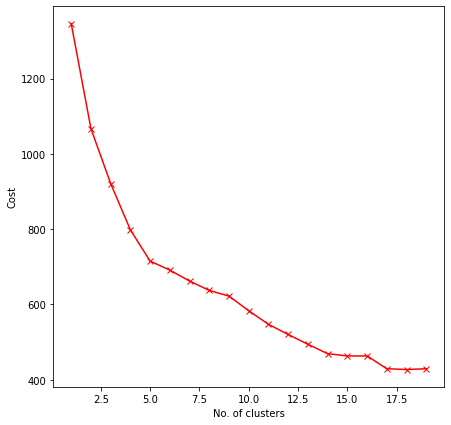

In [8]:
cost = []
K = range(1,20)
for num_clusters in list(K):
    kmode = KModes(n_clusters=num_clusters, init = "random", n_init = 5, verbose=1, random_state = 1)
    kmode.fit_predict(cluster_cols)
    cost.append(kmode.cost_)
    
plt.figure(figsize = (7, 7))
plt.plot(K, cost, 'bx-', color = 'red')

plt.xlabel('No. of clusters')
plt.ylabel('Cost')
plt.show()

In [19]:
kmode = KModes(n_clusters= 10, init = "random", n_init = 5, verbose=0, random_state = 1)
clusters = kmode.fit_predict(cluster_cols)

In [13]:
# this is
kmode.labels_
# same as
clusters

array([2, 9, 4, ..., 7, 0, 2], dtype=uint16)

In [21]:
cluster_cols.insert(0, "Cluster", clusters, True)

In [11]:
cluster_cols.head()

,Cluster,PEDACT,PEDTYPE,PEDCOND
1,1,Crossing with right of way,Vehicle turns left while ped crosses with ROW ...,Unknown
8,1,Crossing with right of way,Vehicle turns left while ped crosses with ROW ...,Normal
21,0,"Crossing, Pedestrian Crossover",Pedestrian hit a PXO/ped. Mid-block signal,Medical or Physical Disability
23,3,Crossing with right of way,Vehicle is going straight thru inter.while ped...,Normal
25,5,Running onto Roadway,Vehicle is going straight thru inter.while ped...,Inattentive


In [22]:
ksi_df.insert(0, 'cluster', clusters, True)

In [11]:
#ksi_df

In [29]:
ksi_df

,cluster,X,Y,INDEX_,ACCNUM,YEAR,DATE,TIME,HOUR,STREET1,STREET2,OFFSET,ROAD_CLASS,DISTRICT,WARDNUM,DIVISION,LATITUDE,LONGITUDE,LOCCOORD,ACCLOC,TRAFFCTL,VISIBILITY,LIGHT,RDSFCOND,ACCLASS,IMPACTYPE,INVTYPE,INVAGE,INJURY,FATAL_NO,INITDIR,VEHTYPE,MANOEUVER,DRIVACT,DRIVCOND,PEDTYPE,PEDACT,PEDCOND,CYCLISTYPE,CYCACT,CYCCOND,PEDESTRIAN,CYCLIST,AUTOMOBILE,MOTORCYCLE,TRUCK,TRSN_CITY_VEH,EMERG_VEH,PASSENGER,SPEEDING,AG_DRIV,REDLIGHT,ALCOHOL,DISABILITY,POLICE_DIVISION,HOOD_ID,NEIGHBOURHOOD,ObjectId
0,7,-8.844611e+06,5.412414e+06,3387730,892658,2006,2006/03/11 05:00:00+00,852,8,BLOOR ST W,DUNDAS ST W,<Null>,Major Arterial,Toronto and East York,4,11,43.656345,-79.452490,Intersection,At Intersection,Traffic Signal,Clear,Daylight,Dry,Fatal,Pedestrian Collisions,Driver,unknown,None,<Null>,South,"Automobile, Station Wagon",Turning Left,Failed to Yield Right of Way,Unknown,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>,Yes,<Null>,Yes,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>,Yes,<Null>,<Null>,<Null>,D11,88,High Park North (88),1
7,7,-8.841082e+06,5.411337e+06,3388371,892913,2006,2006/03/12 05:00:00+00,1903,19,OSSINGTON AVE,DUNDAS ST W,<Null>,Major Arterial,Toronto and East York,"9,11,10",14,43.649345,-79.420790,Intersection,At Intersection,Traffic Signal,Clear,Dark,Dry,Non-Fatal Injury,Pedestrian Collisions,Driver,30 to 34,None,<Null>,East,"Automobile, Station Wagon",Turning Left,Failed to Yield Right of Way,"Ability Impaired, Alcohol Over .08",<Null>,<Null>,<Null>,<Null>,<Null>,<Null>,Yes,<Null>,Yes,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>,Yes,<Null>,Yes,<Null>,D14,81,Trinity-Bellwoods (81),8
20,2,-8.835694e+06,5.412691e+06,3393765,894953,2006,2006/03/16 05:00:00+00,1710,17,DUNDAS ST E,PEMBROKE ST,<Null>,Major Arterial,Toronto and East York,13,51,43.658145,-79.372390,Intersection,<Null>,Pedestrian Crossover,Clear,Daylight,Dry,Non-Fatal Injury,Pedestrian Collisions,Driver,25 to 29,None,<Null>,West,"Automobile, Station Wagon",Going Ahead,Failed to Yield Right of Way,Normal,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>,Yes,<Null>,Yes,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>,Yes,<Null>,<Null>,<Null>,D51,73,Moss Park (73),21
22,2,-8.844388e+06,5.413583e+06,3400106,897335,2006,2006/03/17 05:00:00+00,642,6,SYMINGTON AVE,ANTLER ST,<Null>,Collector,Toronto and East York,9,11,43.663945,-79.450490,Intersection,At Intersection,Stop Sign,Clear,Daylight,Dry,Non-Fatal Injury,Pedestrian Collisions,Driver,40 to 44,None,<Null>,South,"Automobile, Station Wagon",Going Ahead,Failed to Yield Right of Way,Normal,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>,Yes,<Null>,Yes,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>,Yes,<Null>,<Null>,<Null>,D11,93,Dovercourt-Wallace Emerson-Junction (93),23
24,9,-8.840024e+06,5.413768e+06,3400137,897348,2006,2006/03/17 05:00:00+00,1554,15,BLOOR ST W,BATHURST ST,<Null>,Major Arterial,Toronto and East York,11,14,43.665145,-79.411290,Intersection,At Intersection,No Control,Clear,Daylight,Dry,Non-Fatal Injury,Pedestrian Collisions,Driver,40 to 44,None,<Null>,West,"Automobile, Station Wagon",Going Ahead,Driving Properly,Normal,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>,Yes,<Null>,Yes,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>,D14,95,Annex (95),25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16842,8,-8.835937e+06,5.412525e+06,81508821,1573372,2020,2020/08/21 04:00:00+00,1417,14,JARVIS ST,DUNDAS ST E,50 m North of,<Null>,<Null>,<Null>,<Null>,43.657066,-79.374569,Mid-Block,Non Intersection,No Control,Clear,Daylight,Dry,Non-Fatal Injury,Angle,Driver,25 to 29,None,<Null>,West,"Automobile, Station Wagon",Merging,Failed to Yield Right of Way,Normal,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>,Yes,Yes,<Null>,<Null>,<Null>,<Null>,<Null>,Yes,<Null>,<Null>,<Null>,D51,73,Moss Park (73),16843
16843,0,-8.835937e+06,5.412525e+06,81508822,157337

In [58]:
ksi_df.to_csv('ClusterKSI.csv')

In [38]:
cluster_cols[cluster_cols['Cluster'] == 0].apply(lambda x: x.mode())

,Cluster,MANOEUVER,DRIVACT,DRIVCOND,TRAFFCTL,SPEEDING,ALCOHOL,REDLIGHT,AG_DRIV
0,0,Turning Left,Failed to Yield Right of Way,Inattentive,Traffic Signal,<Null>,<Null>,<Null>,Yes


In [39]:
cluster_cols[cluster_cols['Cluster'] == 1].apply(lambda x: x.mode())

,Cluster,MANOEUVER,DRIVACT,DRIVCOND,TRAFFCTL,SPEEDING,ALCOHOL,REDLIGHT,AG_DRIV
0,1,Turning Left,Failed to Yield Right of Way,Normal,Stop Sign,<Null>,<Null>,<Null>,Yes


In [40]:
#cluster_cols[cluster_cols['Cluster'] == 1]

In [41]:
cluster_cols[cluster_cols['Cluster'] == 2].apply(lambda x: x.mode())

,Cluster,MANOEUVER,DRIVACT,DRIVCOND,TRAFFCTL,SPEEDING,ALCOHOL,REDLIGHT,AG_DRIV
0,2,Going Ahead,Driving Properly,Normal,No Control,<Null>,<Null>,<Null>,Yes


In [42]:
cluster_cols[cluster_cols['Cluster'] == 3].apply(lambda x: x.mode())

,Cluster,MANOEUVER,DRIVACT,DRIVCOND,TRAFFCTL,SPEEDING,ALCOHOL,REDLIGHT,AG_DRIV
0,3,Going Ahead,Driving Properly,Normal,No Control,Yes,<Null>,<Null>,Yes


In [43]:
cluster_cols[cluster_cols['Cluster'] == 4].apply(lambda x: x.mode())

,Cluster,MANOEUVER,DRIVACT,DRIVCOND,TRAFFCTL,SPEEDING,ALCOHOL,REDLIGHT,AG_DRIV
0,4,Going Ahead,Driving Properly,Normal,Traffic Signal,<Null>,<Null>,Yes,Yes


In [59]:
#cluster_cols[cluster_cols['Cluster'] == 4]

In [45]:
#ksi_df2[ksi_df2['ACCNUM'] == 1001761]

In [46]:
cluster_cols[cluster_cols['Cluster'] == 5].apply(lambda x: x.mode())

,Cluster,MANOEUVER,DRIVACT,DRIVCOND,TRAFFCTL,SPEEDING,ALCOHOL,REDLIGHT,AG_DRIV
0,5,Stopped,Driving Properly,Normal,Traffic Signal,<Null>,<Null>,<Null>,Yes


In [47]:
cluster_cols[cluster_cols['Cluster'] == 6].apply(lambda x: x.mode())

,Cluster,MANOEUVER,DRIVACT,DRIVCOND,TRAFFCTL,SPEEDING,ALCOHOL,REDLIGHT,AG_DRIV
0,6,Going Ahead,Lost control,Unknown,No Control,<Null>,<Null>,<Null>,<Null>


In [48]:
cluster_cols[cluster_cols['Cluster'] == 7].apply(lambda x: x.mode())

,Cluster,MANOEUVER,DRIVACT,DRIVCOND,TRAFFCTL,SPEEDING,ALCOHOL,REDLIGHT,AG_DRIV
0,7,Going Ahead,Driving Properly,Normal,No Control,<Null>,<Null>,<Null>,<Null>


In [49]:
# checking cluster 7 data

#ksi_df2[ksi_df2['ACCNUM'] == 892682]

In [50]:
cluster_cols[cluster_cols['Cluster'] == 8].apply(lambda x: x.mode())

,Cluster,MANOEUVER,DRIVACT,DRIVCOND,TRAFFCTL,SPEEDING,ALCOHOL,REDLIGHT,AG_DRIV
0,8,Going Ahead,Exceeding Speed Limit,Unknown,Traffic Signal,Yes,<Null>,<Null>,Yes


In [51]:
cluster_cols[cluster_cols['Cluster'] == 8].head(1)

,Cluster,MANOEUVER,DRIVACT,DRIVCOND,TRAFFCTL,SPEEDING,ALCOHOL,REDLIGHT,AG_DRIV
133,8,Changing Lanes,Exceeding Speed Limit,Normal,Traffic Signal,Yes,<Null>,<Null>,Yes


In [52]:
# driver not at fault, pedestrian flouted rules

#ksi_df2[ksi_df2['ACCNUM'] == 893251]

In [53]:
cluster_cols[cluster_cols['Cluster'] == 9].apply(lambda x: x.mode())

,Cluster,MANOEUVER,DRIVACT,DRIVCOND,TRAFFCTL,SPEEDING,ALCOHOL,REDLIGHT,AG_DRIV
0,9,Turning Left,Improper Turn,Normal,Traffic Signal,<Null>,<Null>,<Null>,<Null>


In [54]:
cluster_cols[cluster_cols['Cluster'] == 9].head()

,Cluster,MANOEUVER,DRIVACT,DRIVCOND,TRAFFCTL,SPEEDING,ALCOHOL,REDLIGHT,AG_DRIV
103,9,Turning Left,Improper Turn,Medical or Physical Disability,Traffic Signal,<Null>,<Null>,<Null>,<Null>
113,9,Turning Left,Improper Turn,Normal,Stop Sign,<Null>,<Null>,<Null>,<Null>
154,9,Turning Left,Improper Turn,Normal,Traffic Signal,<Null>,<Null>,<Null>,<Null>
174,9,Turning Left,Lost control,"Ability Impaired, Alcohol Over .08",Traffic Signal,<Null>,Yes,<Null>,<Null>
184,9,Turning Left,Improper Turn,Unknown,Traffic Signal,<Null>,<Null>,<Null>,<Null>


In [55]:
#ksi_df2[ksi_df2['ACCNUM'] == 901141]

In [63]:
#ksi_df2[ksi_df2['ACCNUM'] == 906284]

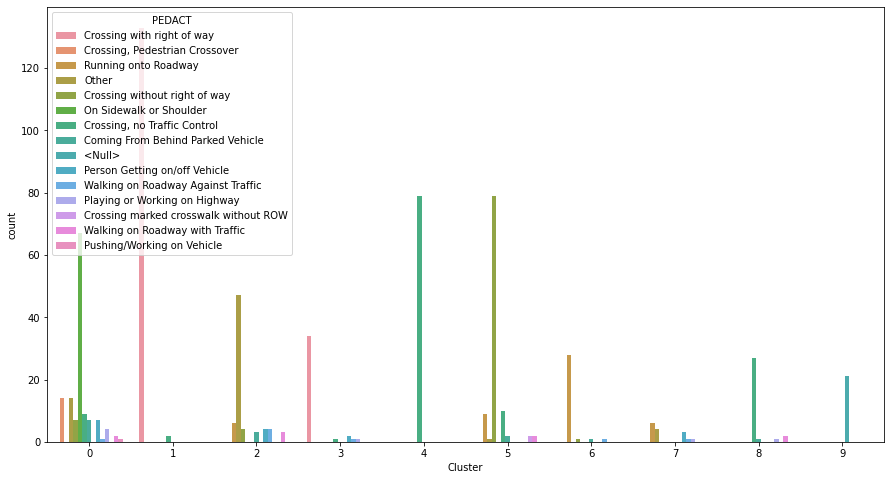

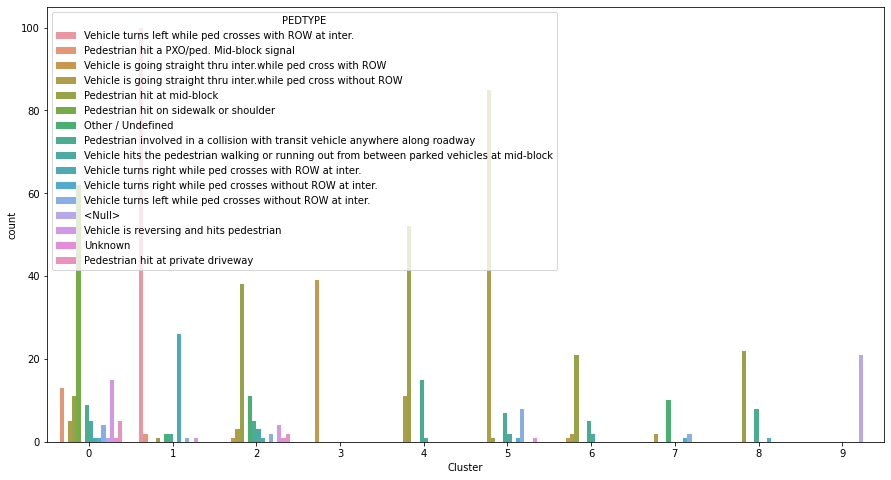

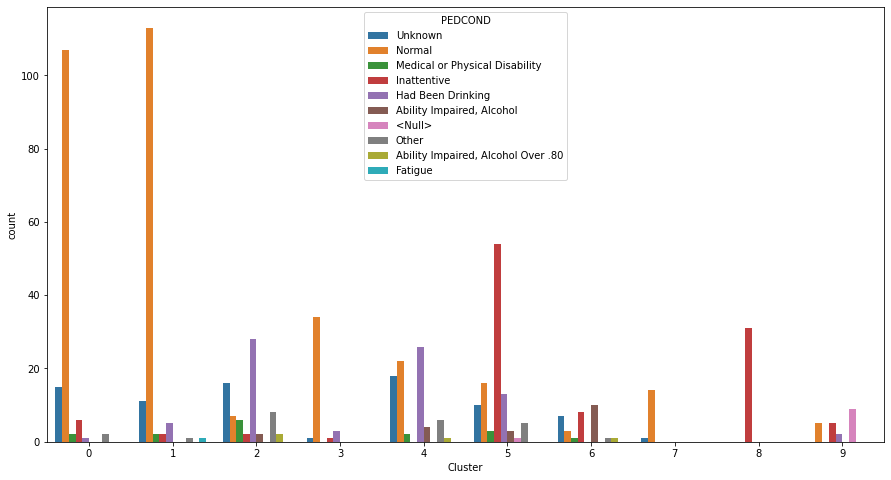

In [13]:
# dt
for col in cols:
    plt.subplots(figsize = (15,8))
    sns.countplot(x= 'Cluster', hue=col, data = cluster_cols)
    plt.show()

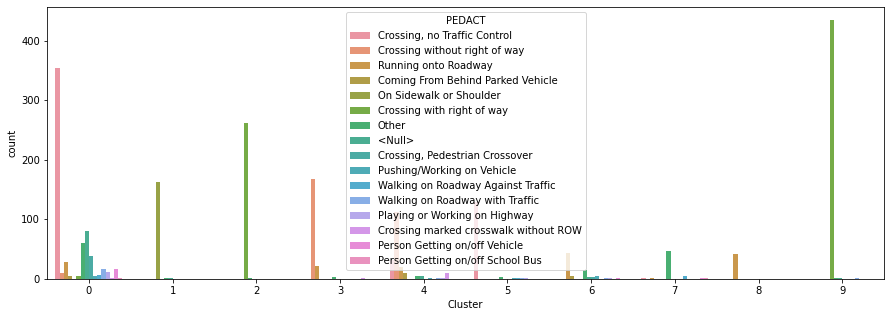

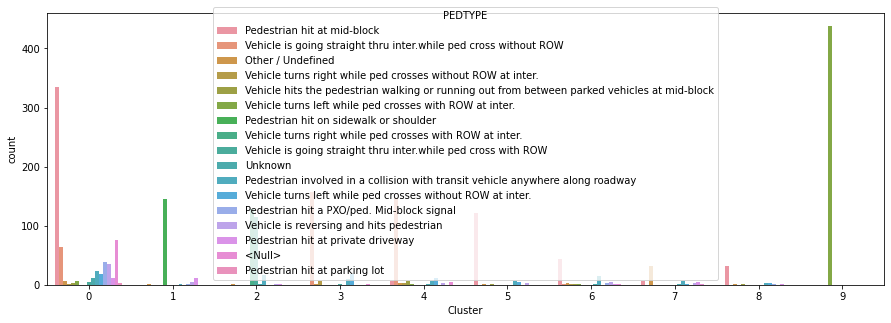

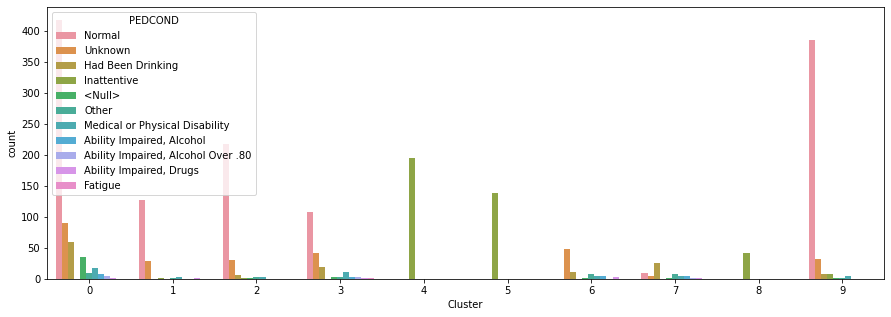

In [23]:
# non dt
for col in cols:
    plt.subplots(figsize = (15,5))
    sns.countplot(x= 'Cluster', hue=col, data = cluster_cols)
    plt.show()